In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Data

In [22]:
# Load dataset with only the ToTensor transform to compute mean and std
compute_transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.FashionMNIST(root='Data',
                                            train=True,
                                            download=True,
                                            transform=compute_transform)
loader = torch.utils.data.DataLoader(dataset,
                          batch_size=1024,
                          num_workers=10,
                          shuffle=True)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

variance = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    variance += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(variance / (len(loader.dataset)*28*28))

print(mean, std)

tensor([0.2860]) tensor([0.3530])


In [23]:
# Load CFashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean,),(std,))])

trainset = torchvision.datasets.FashionMNIST(root='Data',
                                             train=True,
                                             download=True,
                                             transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=1024,
                                          num_workers=10,
                                          shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='Data',
                                            train=False,
                                            download=True,
                                            transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1024,
                                         num_workers=10,
                                         shuffle=True)

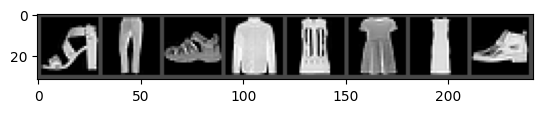

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*std + mean
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

# Model

In [25]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10)
)

model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [26]:
# Generating a random tensor
input_tensor = torch.rand(5, 28, 28)

# Feeding the tensor into the model
output = model(input_tensor)
print(output.shape)

torch.Size([5, 10])


# Loss, Optimizer, and Evaluation Function

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.01)

In [28]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [29]:
test_loss, test_accuracy = evaluate(model, testloader, loss_fn)
print(f'test_loss: {test_loss}')
print(f'test_accuracy: {test_accuracy}')

test_loss: 2.4725160360336305
test_accuracy: 9.66


# Train

In [30]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 20

In [31]:
# train
for epoch in range(max_epoch):
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()        

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, loss_fn)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/20], Loss: 1.1226, Accuracy: 64.82%, Test Loss: 0.8270, Test Accuracy: 72.42%
Epoch [2/20], Loss: 0.7474, Accuracy: 75.40%, Test Loss: 0.7101, Test Accuracy: 75.86%
Epoch [3/20], Loss: 0.6659, Accuracy: 77.94%, Test Loss: 0.6585, Test Accuracy: 77.53%
Epoch [4/20], Loss: 0.6232, Accuracy: 79.20%, Test Loss: 0.6255, Test Accuracy: 78.55%
Epoch [5/20], Loss: 0.5951, Accuracy: 80.12%, Test Loss: 0.6043, Test Accuracy: 79.09%
Epoch [6/20], Loss: 0.5750, Accuracy: 80.62%, Test Loss: 0.5881, Test Accuracy: 79.61%
Epoch [7/20], Loss: 0.5595, Accuracy: 81.14%, Test Loss: 0.5745, Test Accuracy: 79.99%
Epoch [8/20], Loss: 0.5471, Accuracy: 81.57%, Test Loss: 0.5656, Test Accuracy: 80.28%
Epoch [9/20], Loss: 0.5370, Accuracy: 81.88%, Test Loss: 0.5567, Test Accuracy: 80.65%
Epoch [10/20], Loss: 0.5283, Accuracy: 82.17%, Test Loss: 0.5507, Test Accuracy: 80.82%
Epoch [11/20], Loss: 0.5215, Accuracy: 82.32%, Test Loss: 0.5427, Test Accuracy: 80.98%
Epoch [12/20], Loss: 0.5143, Accuracy: 82

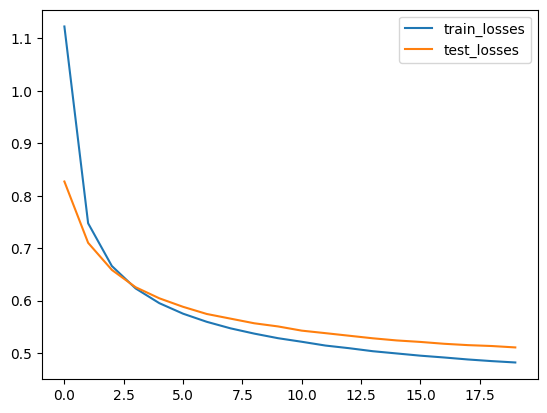

In [32]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

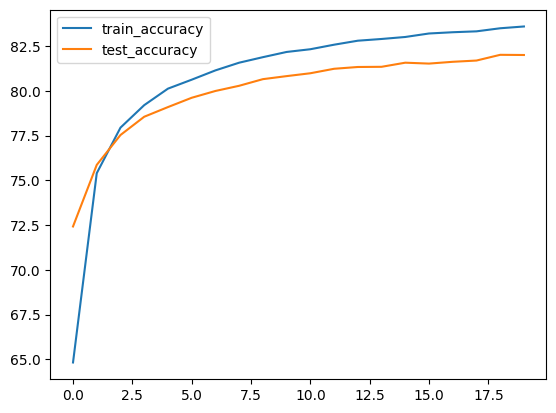

In [33]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()